# BATADAL - ARMA Task

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)).

The purpose of this *ARMA (autoregressive moving average model)* task is to learn an ARMA model for at least 5 individual sensors (pick them in a sensible way!). Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using *Akaike's Information Criterion (AIC)* or another model selection method. Note that there exists a wide range of ARMA variants; we only have to use the basic model. Decide how to set the detection threshold sensibly, study some of the detected anomalies, and answer the following questions:

- What kind of anomalies can you detect using ARMA models? 
- Which sensors can be modeled effectively using ARMA?

## Description of the datasets

Three BATADAL datasets ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)) are available:

1. *Training dataset 1:* A one-year long simulation data, does not contain any attacks, i.e., all te data pertains to C-Town normal operations.
2. *Training dataset 2:* Partially labelled data of around 6 months long and contains several attacks, some of which are approximately labelled.
3. *Test dataset:* A 3-months long dataset which contains several attacks but no labels. Supposed to be used to compare the performance of the algorithms.

*In this ARMA task we use only the two training datasets to demonstrate our work.*

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, ARMA
from statsmodels.tools.eval_measures import mse

## Demonstrate the task with variable L_T3
From the familiarization task we knew that tank T3-related parameters have a relatively clear cyclic behaviour. We first would like to demonstrate the ARMA model with an “easy-to-model” variable. The water level of tank T3, L_T3, was chosen for this demonstration.

### Autocorrelation plots
We therefore first make autocorrelation plots for the variable L_T3 to get familiar with the ARMA process.

In [2]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

Text(0.5, 0, 'Time (hr)')

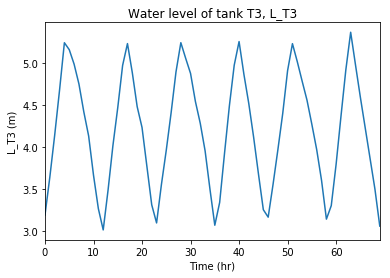

In [22]:
# split the variable in interest (L_T3, tank T3) into training and testing data
n = 24*3 # size of testing data

train = dftrain1.L_T3[:-n]
test = dftrain1.L_T3[-n:]

# plot (a subset of) the training data
train[0:70].plot()
plt.title('Water level of tank T3, L_T3')
plt.ylabel('L_T3 (m)')
plt.xlabel('Time (hr)')

Text(0.5, 0, 'Lag (hour)')

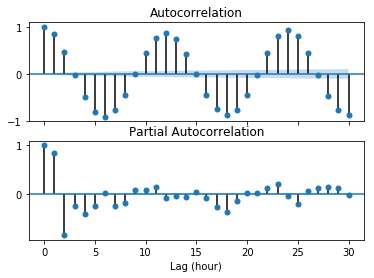

In [21]:
# : plot autocorrelation plot and partial autocorrelation plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (6, 4))

fig = plot_acf(train, lags = 30, ax = ax1)
fig = plot_pacf(train, lags = 30, ax = ax2)

ax2.set_xlabel('Lag (hour)')

It is still difficult to identify the order of the ARMA model. We then make a grid search for finding the order (p, q).

### Akaike Information Critera (AIC)
We can check the order by calculating the Akaike Information Critera (AIC) values for the ARMA models. The AIC is a statistical measure which basically quantifies the 1) the goodness of fit and 2) the simplicity/parsimony of the model into a single statistic ([CoolStatsBlog, 2013](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)). The one with the lower AIC is generally “better”, but we're also interested in the “convergence” of the AIC values, i.e., the “good enough” result with the least computation resources.

In [29]:
ps = range(1, 4+1) # range for AR terms
qs = range(0, 3+1) # range for MA terms

aic = [[p, q, ARMA(train, order=(p, q)).fit().aic] 
       for p in ps for q in qs]
aic = pd.DataFrame(aic, columns = ['p', 'q', 'aic'])

Text(0.5, 1.0, 'AIC Grid')

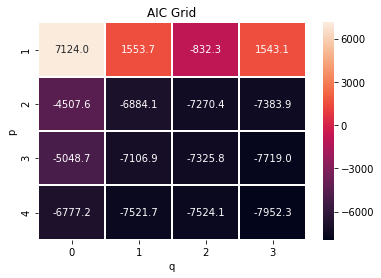

In [30]:
# plot heatmap showing aic values vs (p, q) parameters
sns.heatmap(aic.pivot('p', 'q', 'aic'), 
            annot = True, fmt='0.1f', linewidths=1)
plt.title('AIC Grid')

### Predicting the next value
We can see from the AIC grid graph that higher orders of p and q return a lower AIC score, and that in this grid search, the parameter set of (p, q) = (2, 1) gives a sufficiently good result. After the order of (2, 1), an increase in either p or q gives relatively small improvement in the AIC score. We therefore proceed with an ARMA model with an order of (2, 1).

In [31]:
# train and predict the next time tick of L_T3
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order = (2, 0, 1)).fit()
    output = model.predict(start = len(history), end = len(history))
    predictions.append(float(output))
    history.append(test.values[t])

In [32]:
# calculate mean square error
error = mse(test.values, np.array(predictions))
print('test MSE: %0.3f' % error)

test MSE: 0.024


Text(0.5, 0, 'Time (hr)')

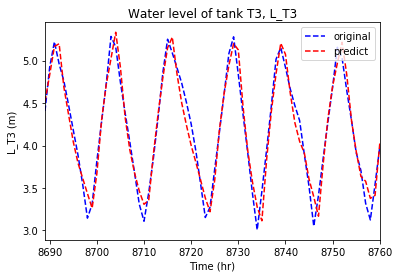

In [33]:
# plot the real vs prediction data
comparison = pd.DataFrame({'original' : test,
                           'predict' : predictions})
comparison.plot(style = ['b--','r--'])
plt.title('Water level of tank T3, L_T3')
plt.ylabel('L_T3 (m)')
plt.xlabel('Time (hr)')

## Detecting anomalies
